## Housing price prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
hdf = pd.read_csv(r'C:\Users\Shiv n\OneDrive\Desktop\py\Housing.csv', encoding= 'unicode_escape')
hdf.head()

,rownames,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,1,42000,5850,3,1,two,yes,no,yes,no,no,1,no
1,2,38500,4000,2,1,one,yes,no,no,no,no,0,no
2,3,49500,3060,3,1,one,yes,no,no,no,no,0,no
3,4,60500,6650,3,1,two,yes,yes,no,no,no,0,no
4,5,61000,6360,2,1,one,yes,no,no,no,no,0,no


###  **Data Preprocessing**

**LabelBinarizer:** This will Converts categorical labels into a one-hot encoded format.Binary (one-hot) matrix, where each row represents one class in binary form. **No ordinal risk; encodes each category independently.**

**One-hot encoding :** If we assign numerical values like 0, 1, 2, 3 to categories, models might interpret them as having a ranking, which can mislead predictions.

Alternatively we can achieve the same using **get_dummies** of pandas package. This is much efficient to use as we can directly use it on the column with text description without having to convert to numbers first.

In [3]:
hdf.select_dtypes(include= 'object').head()

,stories,driveway,recroom,fullbase,gashw,airco,prefarea
0,two,yes,no,yes,no,no,no
1,one,yes,no,no,no,no,no
2,one,yes,no,no,no,no,no
3,two,yes,yes,no,no,no,no
4,one,yes,no,no,no,no,no


In [4]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

hdf['driveway'] = lb.fit_transform(hdf['driveway'])
hdf['recroom'] = lb.fit_transform(hdf['recroom']) 
hdf['fullbase'] = lb.fit_transform(hdf['fullbase'])
hdf['gashw'] = lb.fit_transform(hdf['gashw'])
hdf['airco'] = lb.fit_transform(hdf['airco'])
hdf['prefarea'] = lb.fit_transform(hdf['prefarea'])

hdf.head()

,rownames,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,1,42000,5850,3,1,two,1,0,1,0,0,1,0
1,2,38500,4000,2,1,one,1,0,0,0,0,0,0
2,3,49500,3060,3,1,one,1,0,0,0,0,0,0
3,4,60500,6650,3,1,two,1,1,0,0,0,0,0
4,5,61000,6360,2,1,one,1,0,0,0,0,0,0


In [5]:
# Create dummy variables for stories column

dummy_df = pd.get_dummies(hdf['stories'], prefix= 'stories', drop_first= True)
dummy_df.head()

,stories_one,stories_three,stories_two
0,False,False,True
1,True,False,False
2,True,False,False
3,False,False,True
4,True,False,False


In [6]:
dummy_df['stories_one'] = lb.fit_transform(dummy_df['stories_one'])
dummy_df['stories_two'] = lb.fit_transform(dummy_df['stories_two'])
dummy_df['stories_three'] = lb.fit_transform(dummy_df['stories_three'])

In [7]:
hdf = pd.concat([hdf, dummy_df], axis= 1)    # axis= 1 means (row by row).

In [8]:
del hdf['stories']
hdf.head()

,rownames,price,lotsize,bedrooms,bathrms,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea,stories_one,stories_three,stories_two
0,1,42000,5850,3,1,1,0,1,0,0,1,0,0,0,1
1,2,38500,4000,2,1,1,0,0,0,0,0,0,1,0,0
2,3,49500,3060,3,1,1,0,0,0,0,0,0,1,0,0
3,4,60500,6650,3,1,1,1,0,0,0,0,0,0,0,1
4,5,61000,6360,2,1,1,0,0,0,0,0,0,1,0,0


### Multicollinearity check :

- **Multicollinearity occurs when two or more independent features are internally correlated with each other above 0.7**

however, the exact threshold can vary depending on the use case

In [9]:
independent_feature = hdf.iloc[:, 2:]
independent_feature.head()

,lotsize,bedrooms,bathrms,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea,stories_one,stories_three,stories_two
0,5850,3,1,1,0,1,0,0,1,0,0,0,1
1,4000,2,1,1,0,0,0,0,0,0,1,0,0
2,3060,3,1,1,0,0,0,0,0,0,1,0,0
3,6650,3,1,1,1,0,0,0,0,0,0,0,1
4,6360,2,1,1,0,0,0,0,0,0,1,0,0


In [10]:
target_feature = hdf['price']
target_feature.head()

0    42000
1    38500
2    49500
3    60500
4    61000
Name: price, dtype: int64

### Variance Inflation Factor

- **VIF > 10 is a indicator of high multicollinearity, and these variables should be excluded from the regression model.**

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataset):
    df = pd.DataFrame()
    df['columns'] = dataset.columns
    df['vif_value'] = [variance_inflation_factor(dataset.values, i) for i in range(len(dataset.columns))]
    
    return df

In [12]:
calculate_vif(independent_feature)

,columns,vif_value
0,lotsize,8.958098
1,bedrooms,18.469879
2,bathrms,8.984672
3,driveway,7.088579
4,recroom,1.477015
5,fullbase,2.013320
6,gashw,1.103488
7,airco,1.756746
8,garagepl,1.982649
9,prefarea,1.533295


- **Since, VIF values of bedrooms > 10, we are going to drop this feature to get rid of Multicollinearity**

In [13]:
independent_feature = hdf[['lotsize', 'bathrms', 'driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'garagepl', 'prefarea', 'stories_one', 'stories_two', 'stories_three']]
independent_feature.head()

,lotsize,bathrms,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea,stories_one,stories_two,stories_three
0,5850,1,1,0,1,0,0,1,0,0,1,0
1,4000,1,1,0,0,0,0,0,0,1,0,0
2,3060,1,1,0,0,0,0,0,0,1,0,0
3,6650,1,1,1,0,0,0,0,0,0,1,0
4,6360,1,1,0,0,0,0,0,0,1,0,0


**Correlation plot**

<Axes: >

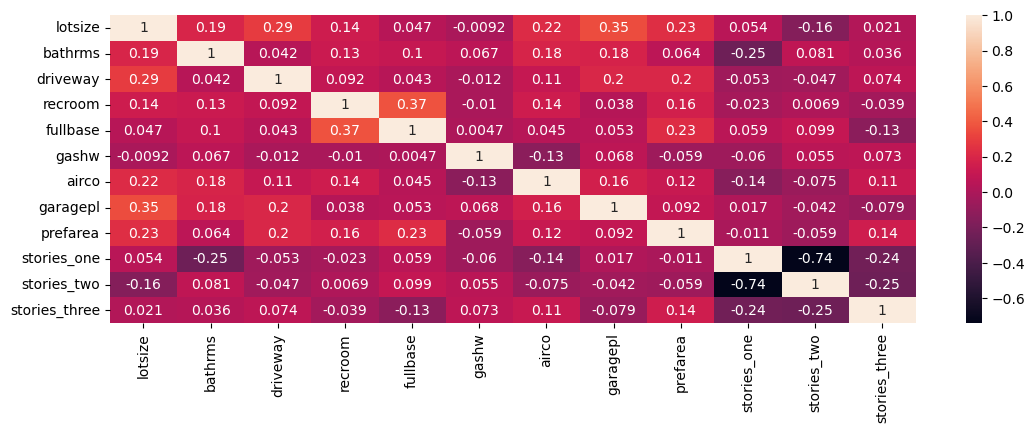

In [14]:
plt.figure(figsize= (13,4))
sns.heatmap(independent_feature.corr(), annot= True)

- **Equation of a Multivariate regression model**

- *y = m1x1 + m2x2 + m3x3 + c*

where,
- *y* = Target feature or what we are going to predict
- *x1, x2, x3* = Independent feature or on the basis of what we are going to predict
- *m1, m2, m3* = Slope or co-efficient (how much changes of y for a unit change in x)
- *c* = Intercept (value of y, when x = 0)

### OLS (Ordinary least square)

- **To calculate the predicted value of y, the intercept (c) has to be multiplied by 1. because it's a constant term that doesn't depend on the value of x.**

In [15]:
import statsmodels.api as sm

y = target_feature
x = sm.add_constant(independent_feature)
x.head()

,const,lotsize,bathrms,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea,stories_one,stories_two,stories_three
0,1.0,5850,1,1,0,1,0,0,1,0,0,1,0
1,1.0,4000,1,1,0,0,0,0,0,0,1,0,0
2,1.0,3060,1,1,0,0,0,0,0,0,1,0,0
3,1.0,6650,1,1,1,0,0,0,0,0,0,1,0
4,1.0,6360,1,1,0,0,0,0,0,0,1,0,0


- We split the data into train/test of 80/20 percent respectively.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size= 0.8, random_state= 1)

# Fit an OLS model

model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     75.77
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           2.38e-97
Time:                        08:11:08   Log-Likelihood:                -4810.4
No. Observations:                 436   AIC:                             9647.
Df Residuals:                     423   BIC:                             9700.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.818e+04   4719.573      5.971      0.000    1.89e+04    3.75e+04
lotsize           3.2416      0.399      8.115      0.000       2.456       4.027
bathrms        1.556e+04   1556.926      9.992      0.000    1.25e+04    1.86e+04
driveway       7242.2434   2210.831      3.276      0.001    2896.661    1.16e+04
recroom        3502.0983   2104.300      1.664      0.097    -634.089    7638.286
fullbase       5728.3011   1768.296      3.239      0.001    2252.560    9204.042
gashw          1.415e+04   3417.279      4.140      0.000    7429.220    2.09e+04
airco          1.226e+04   1754.596      6.989      0.000    8814.294    1.57e+04
garagepl       4809.7385    945.533      5.087      0.000    2951.211    6668.266
prefarea       9250.0096   1958.080      4.724      0.000    5401.230    1.31e+04
stories_one    -2.14e+04   3446.077     -6.209      0.000   -2.82e+04   -1.46e+04
stories_two   -1.482e+04   3375.628     -4.389      0.000   -2.15e+04   -8182.001
stories_three -3373.9529   4125.819     -0.818      0.414   -1.15e+04    4735.707
==============================================================================
Omnibus:                       53.504   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.912
Skew:                           0.674   Prob(JB):                     3.03e-25
Kurtosis:                       5.097   Cond. No.                     5.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- **Lets remove recroom as it has p value > significance level (0.05) and re-run the model.**

In [17]:
independent_feature = hdf[['lotsize', 'bathrms', 'driveway', 'fullbase', 'gashw', 'airco', 'garagepl', 'prefarea', 'stories_one', 'stories_two', 'stories_three']]


In [18]:
y = target_feature
x = sm.add_constant(independent_feature)

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size= 0.8, random_state= 1)

# Fit an OLS model

model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     82.06
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           1.00e-97
Time:                        08:11:13   Log-Likelihood:                -4811.8
No. Observations:                 436   AIC:                             9648.
Df Residuals:                     424   BIC:                             9697.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.805e+04   4728.708      5.931      0.000    1.88e+04    3.73e+04
lotsize           3.3027      0.399      8.285      0.000       2.519       4.086
bathrms        1.565e+04   1559.068     10.041      0.000    1.26e+04    1.87e+04
driveway       7468.7374   2211.239      3.378      0.001    3122.383    1.18e+04
fullbase       6709.2493   1670.645      4.016      0.000    3425.472    9993.027
gashw          1.425e+04   3423.811      4.163      0.000    7522.203     2.1e+04
airco          1.241e+04   1755.934      7.069      0.000    8961.650    1.59e+04
garagepl       4704.8847    945.398      4.977      0.000    2846.634    6563.135
prefarea       9444.6736   1958.659      4.822      0.000    5594.784    1.33e+04
stories_one    -2.17e+04   3448.552     -6.291      0.000   -2.85e+04   -1.49e+04
stories_two   -1.504e+04   3380.099     -4.448      0.000   -2.17e+04   -8392.068
stories_three -3607.7381   4132.023     -0.873      0.383   -1.17e+04    4514.062
==============================================================================
Omnibus:                       50.670   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.174
Skew:                           0.657   Prob(JB):                     6.50e-23
Kurtosis:                       4.974   Cond. No.                     5.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Outliers

*Plotting normalized residual vs leverage to understand the outlier points.*

- **residual:** *difference between observed (actual) and predicted values*  

- **leverage** *is a measure of how far away the independent variable values of an observation are from those of the other observations.*

- **Identify outliers:** *Points with high residuals (vertical distance from the regression line) and Points with high leverage (unusual predictor values) both are most concerning.*

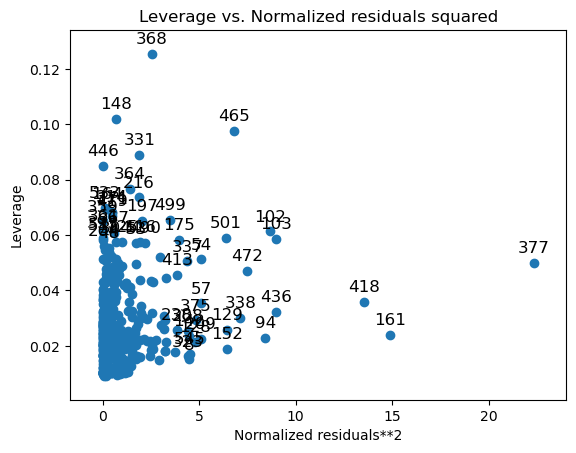

In [19]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

plot_leverage_resid2(model)
plt.show()

- **Homoscedasticity :** *If the residuals show a consistent spread or same variance across all values of the independent variable(s), this indicates homoscedasticity.*

- **Heteroscedasticity :** *if the residuals show variance (spread) gets wider or narrower as the independent variable changes, this indicates heteroscedasticity.*

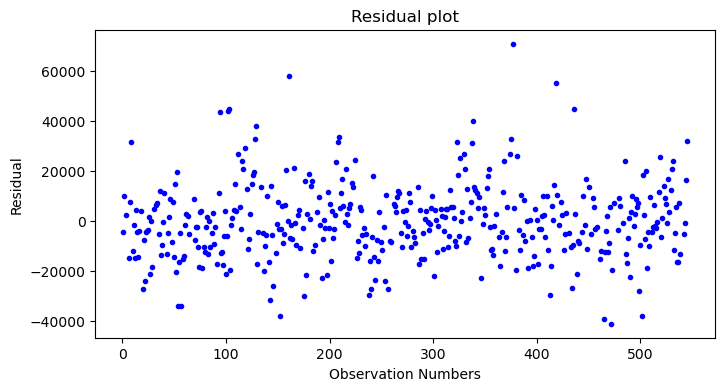

In [20]:
# plot to check homoscedasticity

plt.figure(figsize= (8,4))
plt.plot(model.resid, '.', color= 'blue')              # '.': Point markers.
plt.title('Residual plot')
plt.ylabel('Residual')
plt.xlabel('Observation Numbers')
plt.show()

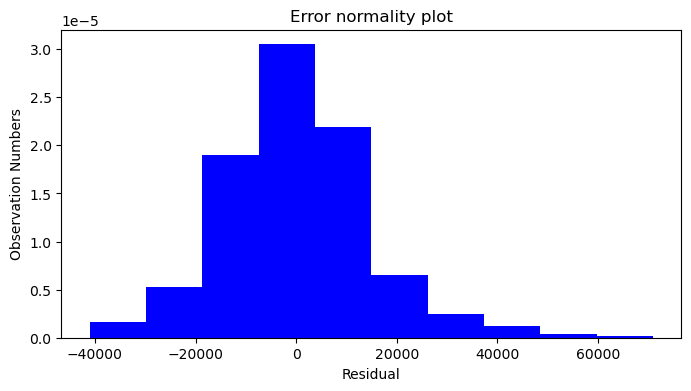

In [21]:
# normality plot

plt.figure(figsize= (8,4))
plt.hist(model.resid, density= True, color= 'blue')
plt.title('Error normality plot')
plt.ylabel('Observation Numbers')
plt.xlabel('Residual')
plt.show()

### If the residual plot is not scattered or not normally distributed then there is a chance that independent variable is not having linear relationship.

In [31]:
from sklearn.linear_model import LinearRegression

y = target_feature
x = sm.add_constant(independent_feature)

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size= 0.8, random_state= 1)

# Fit Linear regression model on the train data

model = LinearRegression()
model_fit = model.fit(X_train, y_train)

In [27]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.6046622415213913

- **R² = 1: Perfect fit. The model explains all the variance in the target variable.**

- **R² = 0: The model explains none of the variance. It’s no better than simply predicting the mean value.**

- **Negative R²: The model performs worse than simply predicting the mean (poor fit)**

In [29]:
model = LinearRegression()
model_fit = model.fit(X_train, y_train)

model_fit.score(X_test, y_test)

0.6046622415213913

- *moderate fit to the test data*

In [30]:
model_fit.score(X_train, y_train)

0.6804043282778162

- *overfitting to the train data*

**For training sample, it gives a good accuracy but for test sample the accuracy is moderate**

### Set Up Cross-Validation for λ (or alpha)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()

# Define range of alpha values

alphas = np.logspace(-4, 4, 50)       # From 10^-4 to 10^4
parameter = {'alpha' : alphas}

In [39]:
# Perform grid search with cross-validation

grid_search = GridSearchCV(estimator= ridge, param_grid= parameter, scoring= 'neg_mean_squared_error', cv= 5)

# cv=5 refers to 5-fold cross-validation

grid_search_fit = grid_search.fit(X_train, y_train)

In [41]:
best_alpha = grid_search_fit.best_params_['alpha']
best_alpha

1.7575106248547894

### Train Ridge Regression with Best λ

In [48]:
ridge_model = Ridge(alpha= best_alpha)
ridge_model_fit = ridge_model.fit(X_train, y_train)

ridge_model_fit.score(X_test, y_test)

0.6039562780307752

In [69]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

16964.48624428404

In [76]:
max_price = hdf['price'].max()
min_price = hdf['price'].min()

data_range = max_price - min_price

perc_of_range = (rmse / data_range) * 100

prediction_accuracy = 100 - perc_of_range
prediction_accuracy

89.7184931852824